In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


### Import Necessary Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix

2024-05-06 15:34:17.650963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:34:17.651080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:34:17.808689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Datasets

In [3]:
df_train = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=None, names=['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content'])
df_train.head()
df_train.shape

(74682, 4)

In [4]:
df_test = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None, names=['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content'])
df_test.head()
df_test.shape

(1000, 4)

### Exploratory Data Analysis

In [5]:
# Rename columns for clarity
df_train.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
df_test.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']

# Drop unnecessary columns
df_train.drop(columns=['Tweet ID', 'Entity'], inplace=True)
df_test.drop(columns=['Tweet ID', 'Entity'], inplace=True)

# Check for missing values
df_train.isnull().sum()
df_test.isnull().sum()

# Drop missing values
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# Check for duplicates
df_train.duplicated().sum()
df_test.duplicated().sum()

# Drop duplicates
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [6]:
twitter_sentiments = pd.concat([df_train,df_test],ignore_index=True)
twitter_sentiments.shape
twitter_sentiments.duplicated().sum()

516

In [7]:
twitter_sentiments.drop_duplicates(inplace=True)

print("Number of duplicates in the twitter_sentiments:", twitter_sentiments.duplicated().sum())
twitter_sentiments.shape

Number of duplicates in the twitter_sentiments: 0


(70252, 2)

In [8]:
twitter_sentiments['Tweet Content Length'] = twitter_sentiments['Tweet Content'].apply(len)
twitter_sentiments.head()
twitter_sentiments.iloc[:5]


,Sentiment,Tweet Content,Tweet Content Length
0,Positive,im getting on borderlands and i will murder yo...,53
1,Positive,I am coming to the borders and I will kill you...,51
2,Positive,im getting on borderlands and i will kill you ...,50
3,Positive,im coming on borderlands and i will murder you...,51
4,Positive,im getting on borderlands 2 and i will murder ...,57


In [9]:
print(f"Sentiment value count: \n {twitter_sentiments['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Negative      21329
Positive      19271
Neutral       17281
Irrelevant    12371
Name: count, dtype: int64


In [10]:
twitter_sentiments['Sentiment'] = twitter_sentiments['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {twitter_sentiments['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Neutral     29652
Negative    21329
Positive    19271
Name: count, dtype: int64


### Distribution of Sentiments

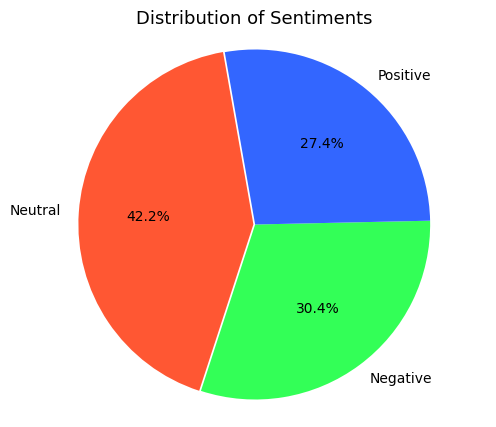

In [11]:
# Data Preparation
sentiments = twitter_sentiments['Sentiment'].value_counts()
labels = sentiments.index
sizes = sentiments.values
colors = ['#FF5733', '#33FF57', '#3366FF']
explode = (0.01, 0, 0)  

# Plotting
plt.figure(figsize=(6,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.01f%%', startangle=100)
plt.title('Distribution of Sentiments', fontsize=13)
plt.axis('equal')

# Show plot
plt.show()

### Distribution of Tweet Content Length

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


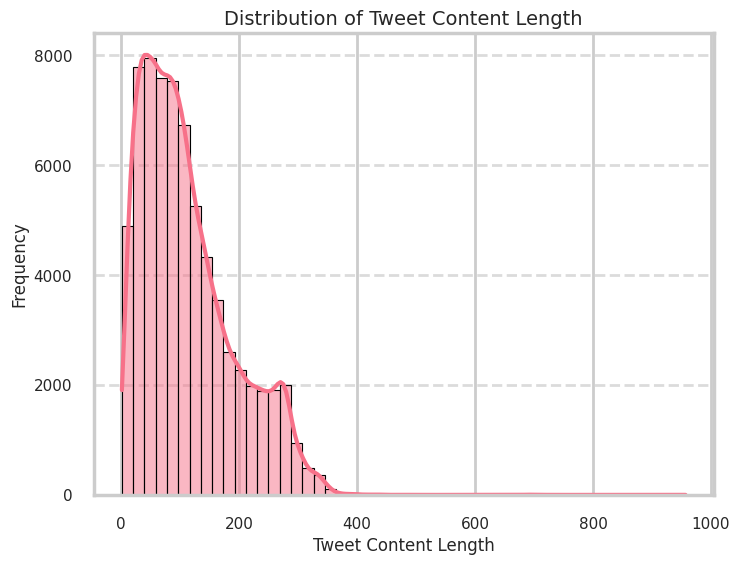

In [12]:
sns.set_style("whitegrid")
sns.set_context("poster")

custom_palette = sns.color_palette("husl")

plt.figure(figsize=(8, 6))
sns.histplot(data=twitter_sentiments, x='Tweet Content Length', bins=50, kde=True, color=custom_palette[0], edgecolor='black')

plt.xlabel('Tweet Content Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Tweet Content Length', fontsize=14)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Distribution of Tweet Content Length by Sentiment

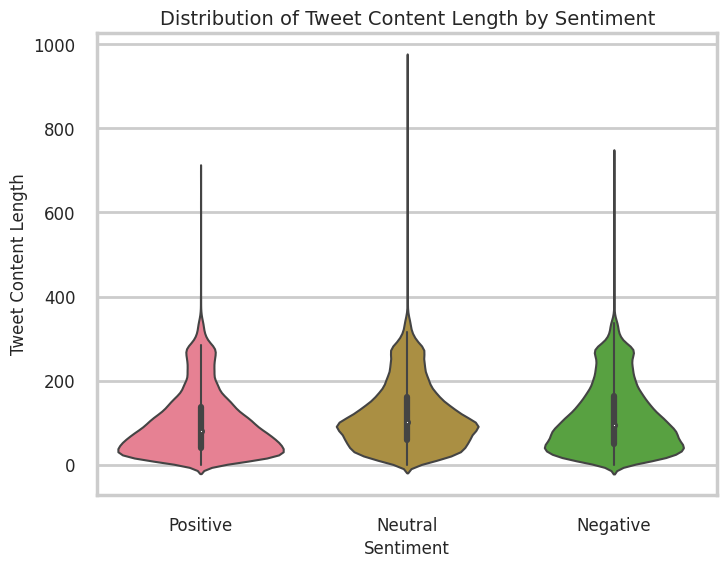

In [13]:
sns.set_style("whitegrid")
sns.set_context("poster")

# Define a custom color palette
custom_palette = sns.color_palette("husl")

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=twitter_sentiments, x='Sentiment', y='Tweet Content Length', palette=custom_palette, linewidth=1.5)

# Add labels and title
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Tweet Content Length', fontsize=12)
plt.title('Distribution of Tweet Content Length by Sentiment', fontsize=14)

# Adjust tick font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

### Data Preprocessing

In [14]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text: str) -> str:
    text = text.lower()
    text = remove_special_characters_and_emojis(text)
    text = remove_urls(text)
    text = remove_mentions_and_hashtags(text)
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespaces(text)
    text = tokenize_and_lemmatize(text)
    return text

def remove_urls(text: str) -> str:
    return re.sub(r'https*\S+', ' ', text)

def remove_mentions_and_hashtags(text: str) -> str:
    return re.sub(r'[@#]\S+', ' ', text)

def remove_html_tags(text: str) -> str:
    return re.sub('<.*?>', '', text)

def expand_contractions(text: str) -> str:
    contractions = {"don't": 'do not', "can't": 'cannot'}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text

def remove_punctuation(text: str) -> str:
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)

def remove_extra_whitespaces(text: str) -> str:
    return re.sub('\s{2,}', ' ', text)

def remove_special_characters_and_emojis(text: str) -> str:
    special_char_pattern = r'[^a-zA-Z0-9\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]'

    return re.sub(special_char_pattern, '', text)

def tokenize_and_lemmatize(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
# Clean the tweets
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
df_train['cleaned_tweet'] = df_train['Tweet Content'].apply(clean_text)
df_test['cleaned_tweet'] = df_test['Tweet Content'].apply(clean_text)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [16]:
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_train['Sentiment'].value_counts()}")
df_test['Sentiment'] = df_test['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_test['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Neutral     29394
Negative    21237
Positive    19138
Name: count, dtype: int64
Sentiment value count: 
 Sentiment
Neutral     457
Positive    276
Negative    266
Name: count, dtype: int64


In [17]:
# Encode Sentiment labels
label_encoder = LabelEncoder()
df_train['encoded_sentiment'] = label_encoder.fit_transform(df_train['Sentiment'])
df_test['encoded_sentiment'] = label_encoder.transform(df_test['Sentiment'])

### Word2Vec Embedding

In [18]:
# Combine text from both datasets for Word2Vec training
twitter_sentiments = pd.concat([df_train['cleaned_tweet'], df_test['cleaned_tweet']])

# Tokenize tweets for Word2Vec
tokenized_tweets = [tweet.split() for tweet in twitter_sentiments]

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, sample=1e-3, epochs=10)

### Prepare Tokenization and Padding

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(twitter_sentiments)

# Convert tweets to sequences
train_sequences = tokenizer.texts_to_sequences(df_train['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])

# Pad sequences
X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

# Prepare labels
y_train = df_train['encoded_sentiment']
y_test = df_test['encoded_sentiment']

### Build and Compile the LSTM Model

In [20]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax')) # 3 units for 'Positive', 'Negative', 'Neutral'

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [21]:
history = model.fit(X_train, y_train, epochs=35, batch_size=128, validation_split=0.2)

Epoch 1/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 186s 416ms/step - accuracy: 0.5933 - loss: 0.8403 - val_accuracy: 0.5429 - val_loss: 1.2287
Epoch 2/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 181s 415ms/step - accuracy: 0.8950 - loss: 0.2742 - val_accuracy: 0.5216 - val_loss: 1.7557
Epoch 3/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 202s 416ms/step - accuracy: 0.9430 - loss: 0.1504 - val_accuracy: 0.5091 - val_loss: 1.8702
Epoch 4/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 180s 412ms/step - accuracy: 0.9594 - loss: 0.1072 - val_accuracy: 0.5093 - val_loss: 2.1550
Epoch 5/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 181s 415ms/step - accuracy: 0.9667 - loss: 0.0859 - val_accuracy: 0.5064 - val_loss: 2.5930
Epoch 6/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 197s 405ms/step - accuracy: 0.9711 - loss: 0.0737 - val_accuracy: 0.4963 - val_loss: 2.6242
Epoch 7/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 177s 405ms/step - accuracy: 0.9754 - loss: 0.0637 - val_accuracy: 0.4970 - val_loss: 2.7828
Epoch 8/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 207s 417ms/step - accuracy: 0.9759 -

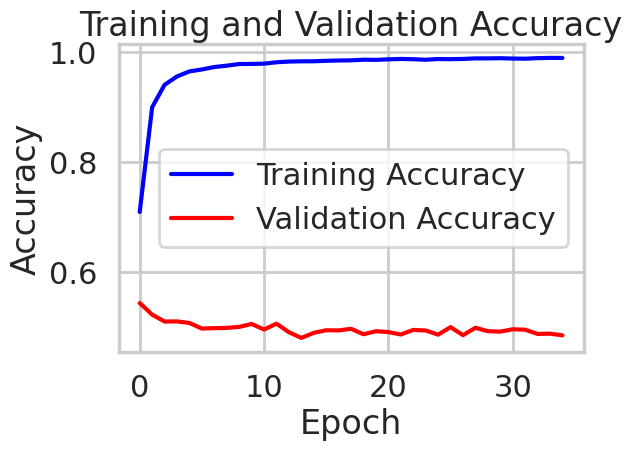

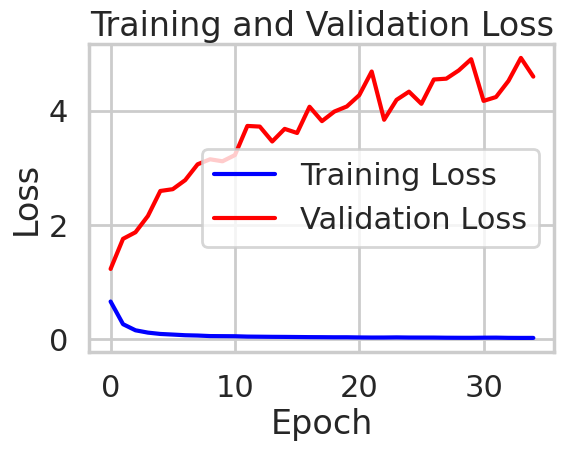

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Evaluate the Model

In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8731 - loss: 0.9935
Test Loss: 1.1041653156280518
Test Accuracy: 0.8618618845939636


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


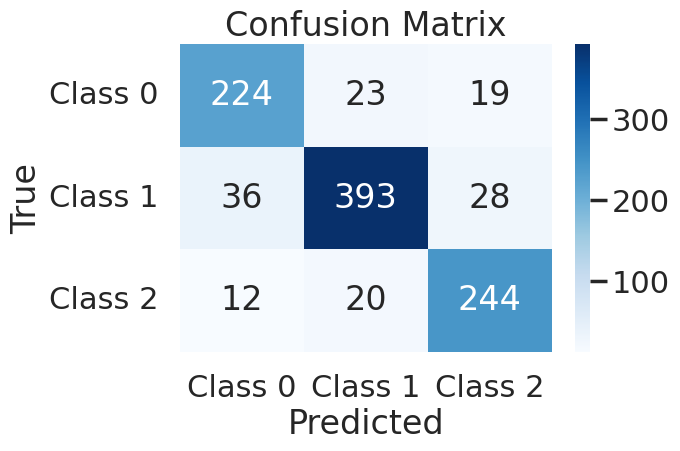

In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 